In [1]:
import pandas as pd
import numpy as np
from string import punctuation
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from rapidfuzz import fuzz, process

In [2]:
streetcar_df = pd.read_csv('ttc-streetcar-delay-data-2024.csv')
stops_df = pd.read_csv('stops.csv')

In [3]:
streetcar_df.columns = [s.strip().replace(' ','_') for s in streetcar_df.columns]
streetcar_df.rename(columns={'Bound': 'Direction'}, inplace=True)
streetcar_df.rename(columns={'Line': 'Route'}, inplace=True)
stops_df.rename(columns={'stop_lat': 'Latitude'}, inplace=True)
stops_df.rename(columns={'stop_lon': 'Longtitude'}, inplace=True)
streetcar_df['TransportType'] = 'StreetCar'
streetcar_df = streetcar_df.drop( columns = ['Min_Gap'])

In [4]:
streetcar_df.head()

,Date,Route,Time,Day,Location,Incident,Min_Delay,Direction,Vehicle,TransportType
0,1-Jan-24,505,02:45,Monday,DUNDAS AND MCCAUL,Security,10,W,4416,StreetCar
1,1-Jan-24,505,03:06,Monday,COLLEGE AND GLADSTONE,Emergency Services,52,E,4461,StreetCar
2,1-Jan-24,503,03:21,Monday,PARLIAMENT AND SHUTTER,Security,0,N,4545,StreetCar
3,1-Jan-24,505,03:53,Monday,DUNDAS WEST STATION,Security,37,W,4551,StreetCar
4,1-Jan-24,600,04:27,Monday,QUEEN AND BATHURST,Diversion,78,E,8116,StreetCar


In [5]:
streetcar_df.nunique()

Date              274
Route              38
Time             1435
Day                 7
Location         1819
Incident           13
Min_Delay         197
Direction           6
Vehicle          1076
TransportType       1
dtype: int64

### 1.1 Missing Values

In [6]:
streetcar_df.isnull().sum()

Date                0
Route             120
Time                0
Day                 0
Location            1
Incident            0
Min_Delay           0
Direction        1540
Vehicle             0
TransportType       0
dtype: int64

### 1.2 Date Formatting 

In [7]:
# Function to split the date
def split_date(date_str):
    # Convert the date string to a datetime object
    # Check if date is in 1-Jan-24 format
    if re.match(r"\d{1,2}-[A-Za-z]{3,4}-\d{2}", date_str):
        date_obj = pd.to_datetime(date_str, format='%d-%b-%y')
    # Check if date is in 2024-01-01 format
    elif re.match(r"\d{4}-\d{2}-\d{2}", date_str):
        date_obj = pd.to_datetime(date_str, format='%Y-%m-%d')
    else:
        raise ValueError(f"Unknown date format: {date_str}")

    # Extract day, month, and year
    day = date_obj.day
    month = date_obj.month
    year = date_obj.year
   
    # Standardize to DD-MM-YYYY
    return datetime(year, month, day).strftime("%d-%m-%Y")

In [8]:
streetcar_df.loc[:, 'Date'] = streetcar_df.loc[:,'Date'].apply(split_date)

### 1.3 Delays

In [9]:
# on time is 0 mins delays
# short delay is 1 to 15 mins.
# medium delay is 15 to 30 mins.
# long delay is more than 30 mins.
def delay_type(col):
    if col == 0 :
        return 'on-time'
    elif col >= 1 and col <= 15:
        return 'short'
    elif col > 15 and col <= 30:
        return 'medium'
    elif col > 30:
        return 'long'

# apply delay_type function
streetcar_df['delay_type'] = streetcar_df['Min_Delay'].apply(delay_type)

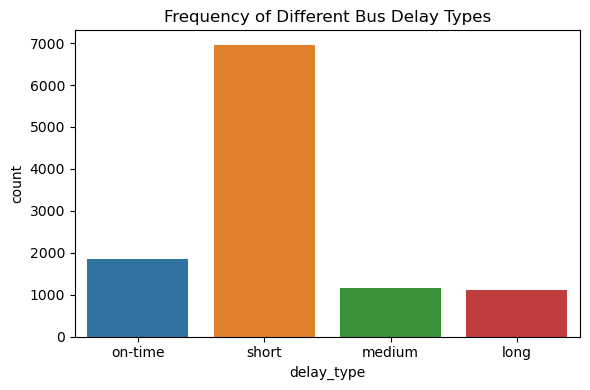

In [10]:
datasets = [streetcar_df]
titles = ['Bus Delay Types']
delay_type_order = ['on-time', 'short', 'medium', 'long']

# Loop through each dataset and create a separate plot
for i, df in enumerate(datasets):
    plt.figure(figsize=(6, 4))
    sns.countplot(x='delay_type', data=df, order=delay_type_order)
    plt.title(f'Frequency of Different {titles[i]}')
    plt.tight_layout()
    plt.show()

### 1.4 Filtering out Irrelevent Directions

In [11]:
# function to simplify direction in to N,S,E,W,B and NaN.
def direction_filter(direction):
    # convert all lowercase characters to uppercase, replace punctuations with empty space and remove leading and the trailing spaces.
    direction = str(direction).upper().replace(rf'[{punctuation}]', '').strip()
    if 'N' in direction:
        return 'N'
    elif 'S' in direction:
        return 'S'
    elif 'E' in direction:
        return 'E'
    elif 'W' in direction:
        return 'W'
    elif 'B' in direction:
        return 'B'
    else:
        'NaN'

streetcar_df['Direction'] = streetcar_df['Direction'].apply(direction_filter)

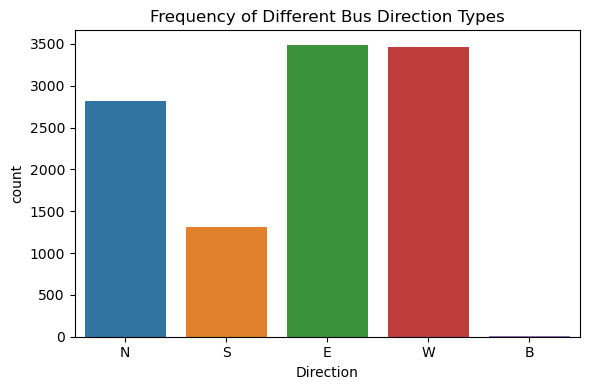

In [12]:
datasets = [streetcar_df]
titles = ['Bus Direction Types']
Direction_order = ['N', 'S', 'E', 'W', 'B']

for i, df in enumerate(datasets):
    plt.figure(figsize=(6, 4))
    sns.countplot(x='Direction', data=df, order=Direction_order)
    plt.title(f'Frequency of Different {titles[i]}')
    plt.tight_layout()
    plt.show()

In [13]:
streetcar_df = streetcar_df.dropna(subset = ['Route', 'Location', 'Direction'])

In [14]:
streetcar_df.isnull().sum()

Date             0
Route            0
Time             0
Day              0
Location         0
Incident         0
Min_Delay        0
Direction        0
Vehicle          0
TransportType    0
delay_type       0
dtype: int64

### Joining columns of stops.csv & bus data

In [15]:
stops_df = stops_df.drop(columns=['stop_id', 'stop_code','stop_desc', 'zone_id', 'stop_url', 'location_type', 'parent_station', 'stop_timezone'])

### Normalizing text in both datasets

In [16]:
#from rapidfuzz import fuzz, process

# Function to normalize text (expand abbreviations and remove unnecessary words)
def normalize_text(text):
    text = text.lower()
    text = text.replace(' st ', ' ')
    text = text.replace(' ave ', ' ')
    text = text.replace(' avenue ', ' ')
    text = text.replace(' street ', ' ')
    text = text.replace(' at ', ' ')
    text = text.replace(' and ', ' ')
    text = text.replace(' side ', ' ')
    text = text.replace(' hwy ', ' highway ')    
    text = text.replace(' east ', ' ')
    text = text.replace(' west ', ' ')
    text = text.replace(' north ', ' ')
    text = text.replace(' south ', ' ')
    return text.strip()

# Normalize the relevant columns
streetcar_df.loc[:, 'Normalized_Location'] = streetcar_df.loc[:,'Location'].apply(normalize_text)
stops_df.loc[:, 'Normalized_stop_name'] = stops_df.loc[:,'stop_name'].apply(normalize_text)

C:\Users\Jugal Patel\AppData\Local\Temp\ipykernel_18368\3601545013.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streetcar_df.loc[:, 'Normalized_Location'] = streetcar_df.loc[:,'Location'].apply(normalize_text)


### Using fuzzy matching

In [17]:
# Perform fuzzy matching for unmatched records
def fuzzy_match(location, stop_names, threshold=80):
    match = process.extractOne(location, stop_names, scorer=fuzz.token_set_ratio)
    if match and match[1] >= threshold:
        return match[0]  # Return the best match if similarity exceeds the threshold
    return None

In [18]:
# Create a list of normalized stop names for matching
normalized_stop_names = stops_df['Normalized_stop_name'].tolist()

# Apply fuzzy matching
streetcar_df.loc[:, 'Fuzzy_stop_name'] = streetcar_df.loc[:, 'Normalized_Location'].apply(
    lambda x: fuzzy_match(x, normalized_stop_names)
)

C:\Users\Jugal Patel\AppData\Local\Temp\ipykernel_18368\3450373901.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streetcar_df.loc[:, 'Fuzzy_stop_name'] = streetcar_df.loc[:, 'Normalized_Location'].apply(


In [19]:
# Select required columns from streetcar_df and stops_df
bus_columns = ['Date', 'TransportType', 'Route', 'Time', 'Day', 'Location', 'Incident', 'Min_Delay',
               'Direction', 'Vehicle', 'delay_type', 'Fuzzy_stop_name']
stops_columns = ['Latitude', 'Longtitude', 'wheelchair_boarding']

# Merge the datasets while retaining all records from streetcar_df and matched stop details
merged_data_fuzzy = pd.merge(
    streetcar_df[bus_columns],
    stops_df[stops_columns + ['Normalized_stop_name']],
    left_on='Fuzzy_stop_name',
    right_on='Normalized_stop_name',
    how='left'
)

In [20]:
# Check unmatched records
unmatched_fuzzy_records = merged_data_fuzzy[merged_data_fuzzy['Normalized_stop_name'].isna()]
unmatched_fuzzy_count = unmatched_fuzzy_records.shape[0]

In [21]:
unmatched_fuzzy_count

1830

In [22]:
# Drop 'Normalized_stop_name' & 'Fuzzy_stop_name' since it's not required in the final output
merged_data_fuzzy.drop(columns=['Normalized_stop_name', 'Fuzzy_stop_name'], inplace=True)

In [24]:
# Filter out unmatched records
cleaned_streetcar_df = merged_data_fuzzy[~merged_data_fuzzy['Latitude'].isna()]

# Save the cleaned dataset
cleaned_streetcar_df.to_csv('C:\\Users\\Jugal Patel\\Desktop\\Capstone project\\Data_cleaning\\Merged_streetcar.csv', index=False)

print(f"Cleaned bus dataset saved with {cleaned_streetcar_df.shape[0]} records.")

Cleaned bus dataset saved with 17003 records.


In [26]:
merged_data_fuzzy.head()

,Date,TransportType,Route,Time,Day,Location,Incident,Min_Delay,Direction,Vehicle,delay_type,Latitude,Longtitude,wheelchair_boarding
0,01-01-2024,StreetCar,505,02:45,Monday,DUNDAS AND MCCAUL,Security,10,W,4416,short,43.654219,-79.391552,2.0
1,01-01-2024,StreetCar,505,03:06,Monday,COLLEGE AND GLADSTONE,Emergency Services,52,E,4461,long,NaN,NaN,NaN
2,01-01-2024,StreetCar,503,03:21,Monday,PARLIAMENT AND SHUTTER,Security,0,N,4545,on-time,43.656843,-79.364855,1.0
3,01-01-2024,StreetCar,503,03:21,Monday,PARLIAMENT AND SHUTTER,Security,0,N,4545,on-time,43.657021,-79.365124,1.0
4,01-01-2024,StreetCar,505,03:53,Monday,DUNDAS WEST STATION,Security,37,W,4551,long,43.656196,-79.380763,1.0
